# Experiment I

### Loading and Data Inspection

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Baseline (Neutral)
file_path = "neutral_activations_v2.pt"
data = torch.load(file_path, map_location='cpu')

# Converting the dict of 100 questions into a structured NumPy array
# Shape: [100, 29, 4096]
raw_acts = np.stack([data[f"q_{i}"].float().numpy() for i in range(1, 101)])

# Calculate mean activity for each unit [Layer, Neuron]
mean_neutral = np.mean(raw_acts, axis=0)

print(f"Neutral baseline matrix created: {mean_neutral.shape}")
print("This matrix represents the resting brain state of Qwen2-VL for math tasks.")

Neutral baseline matrix created: (29, 3584)
This matrix represents the resting brain state of Qwen2-VL for math tasks.


In [3]:
print("Full Matrix (Summary):")
print(mean_neutral)
print("\nShape of the matrix:", mean_neutral.shape)

Full Matrix (Summary):
[[ 9.9182129e-04  2.0751953e-03 -4.1503906e-03 ... -1.5335083e-03
   2.1820068e-03 -4.7912598e-03]
 [-8.2167968e-02 -3.9909668e-02 -5.0004885e-02 ...  1.2129883e-01
   1.2020996e-01  2.7360840e-02]
 [ 4.3798829e-03 -1.9268189e-02 -1.9288940e-02 ...  8.8393554e-02
   8.2631834e-02 -4.0092774e-02]
 ...
 [-9.9357420e-01  8.5541260e-01  2.5080664e+00 ...  4.7685156e+00
   8.0479491e-01 -1.1674609e+00]
 [-1.1318653e+00 -5.4677737e-01  5.0994530e+00 ...  7.6334376e+00
   2.9544141e+00 -1.2781323e+00]
 [-2.6864746e+00  1.4131665e+00  2.5341992e+00 ...  5.5095310e+00
   1.6793090e-01  6.8781741e-02]]

Shape of the matrix: (29, 3584)


In [4]:
# [Layer index, Neuron start:Neuron end]
print("First 20 neurons of Layer 28:")
print(mean_neutral[28, 0:20])

First 20 neurons of Layer 28:
[-2.6864746   1.4131665   2.5341992   2.2947803  -0.01750778 -1.9141114
  1.3716642   0.7875586   2.0082617  -3.3189063  -1.9842334  -6.049375
  0.9785205  -1.7097949  -0.8346814   1.0259826   0.3170752  -0.35499632
  1.8719091  -0.18562989]


In [5]:
print("Matrix Statistics:")
print(f"Max activation: {mean_neutral.max():.4f}")
print(f"Min activation: {mean_neutral.min():.4f}")
print(f"Average activation: {mean_neutral.mean():.4f}")
print(f"Standard Deviation: {mean_neutral.std():.4f}")

Matrix Statistics:
Max activation: 63.3575
Min activation: -201.6400
Average activation: -0.0182
Standard Deviation: 1.8933


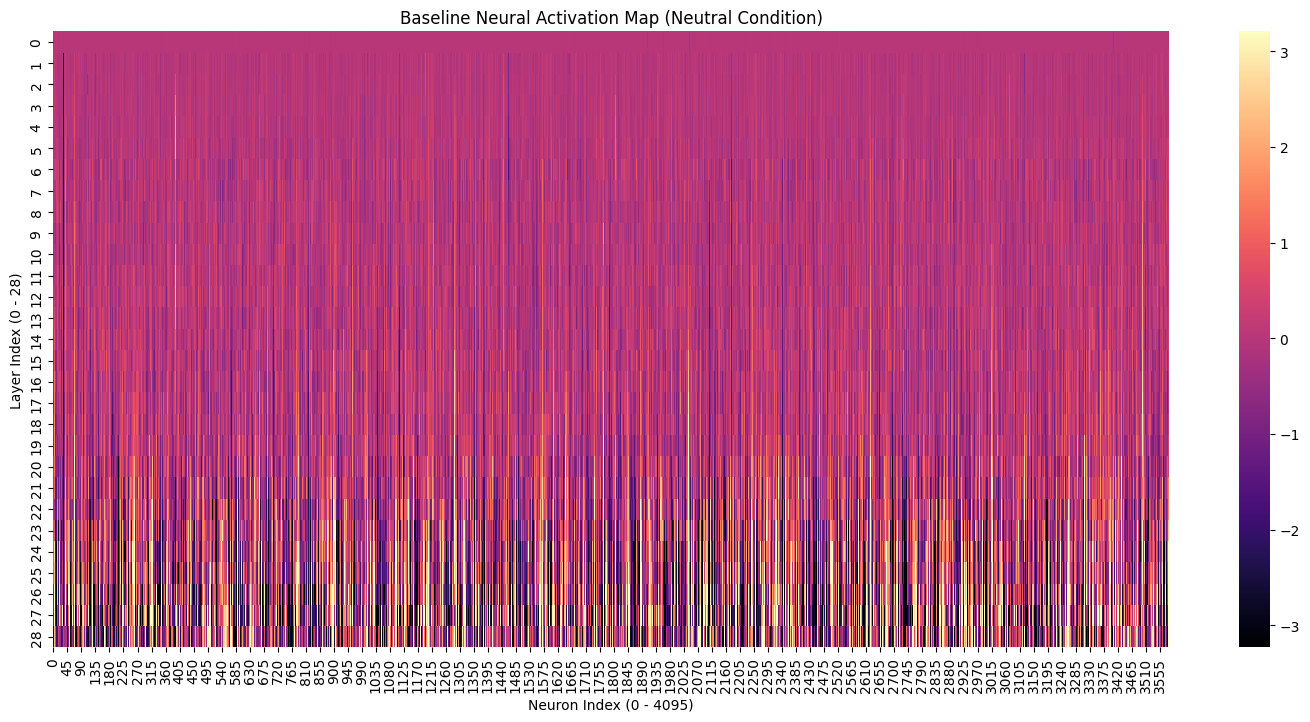

In [6]:
plt.figure(figsize=(18, 8))
# Using 'magma' for high contrast to see sparse firing patterns
sns.heatmap(mean_neutral, cmap='magma', robust=True)

plt.title("Baseline Neural Activation Map (Neutral Condition)")
plt.xlabel("Neuron Index (0 - 4095)")
plt.ylabel("Layer Index (0 - 28)")
plt.show()

## Reward 

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Loading the Reward activations
# This file contains the brain states when the model was promised a "Great Reward"
file_path_reward = "reward_activations_v2.pt"
data_reward = torch.load(file_path_reward, map_location='cpu')

# 2. Converting the dict of 100 questions into a structured NumPy array
# Shape: [100, 29, 4096]
raw_acts_reward = np.stack([data_reward[f"q_{i}"].float().numpy() for i in range(1, 101)])

# 3. Calculate mean activity for each unit [Layer, Neuron]
# This computes the average "Reward-Induced" state across all samples
mean_reward = np.mean(raw_acts_reward, axis=0)

print(f"Reward matrix created: {mean_reward.shape}")
print("This matrix represents the brain state under Verbal Reward incentive.")

# 4. Comparative Statistics
print("\n--- Reward Matrix Statistics ---")
print(f"Max activation: {mean_reward.max():.4f}")
print(f"Min activation: {mean_reward.min():.4f}")
print(f"Average activation: {mean_reward.mean():.4f}")
print(f"Standard Deviation: {mean_reward.std():.4f}")

Reward matrix created: (29, 3584)
This matrix represents the brain state under Verbal Reward incentive.

--- Reward Matrix Statistics ---
Max activation: 63.2250
Min activation: -208.5000
Average activation: -0.0135
Standard Deviation: 1.8803


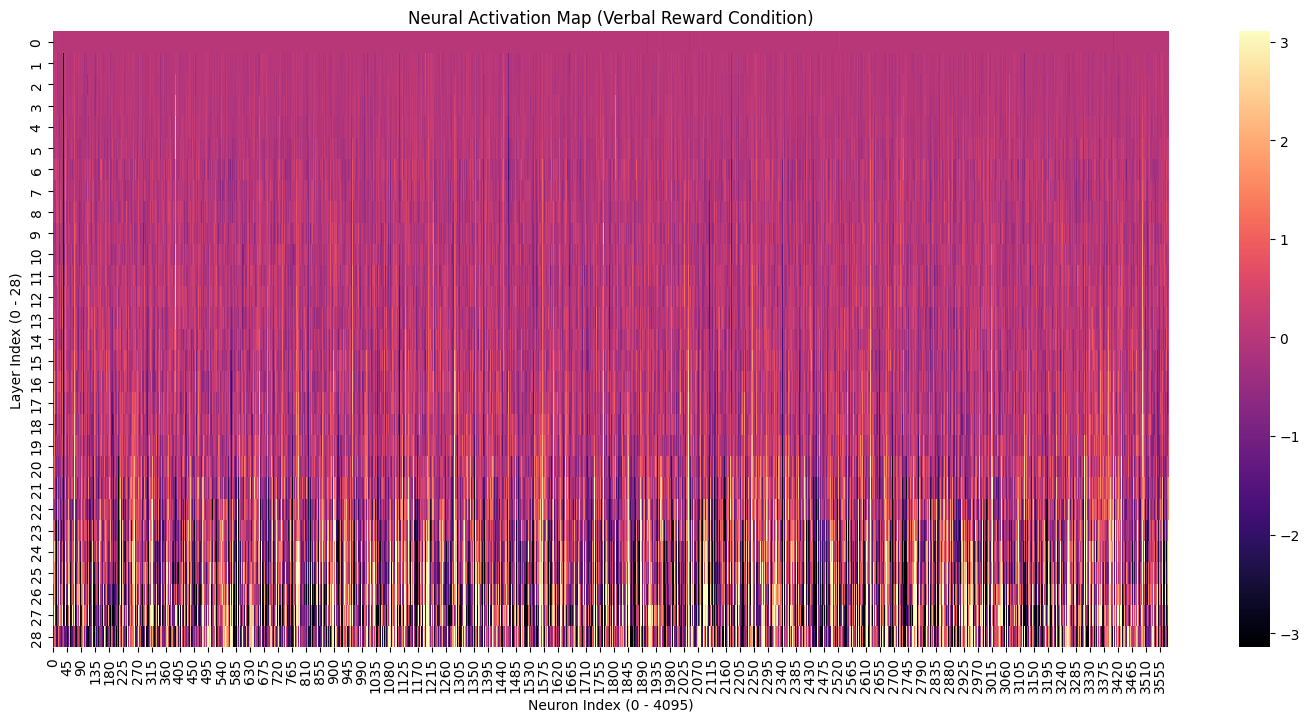

In [8]:
plt.figure(figsize=(18, 8))
# Using 'magma' to keep the visual scale consistent with your Neutral map
sns.heatmap(mean_reward, cmap='magma', robust=True)

plt.title("Neural Activation Map (Verbal Reward Condition)")
plt.xlabel("Neuron Index (0 - 4095)")
plt.ylabel("Layer Index (0 - 28)")
plt.show()

### Calculating the Reward Signal (Delta)

In [9]:
# Calculate the difference
# Positive values = Activation increased due to Reward
# Negative values = Activation decreased (Inhibition)
delta_reward = mean_reward - mean_neutral

print(f"Delta matrix calculated. Shape: {delta_reward.shape}")
print(f"Mean change across all units: {np.abs(delta_reward).mean():.6f}")

Delta matrix calculated. Shape: (29, 3584)
Mean change across all units: 0.226910


### Comparative Heatmap (The "Incentive Signature")

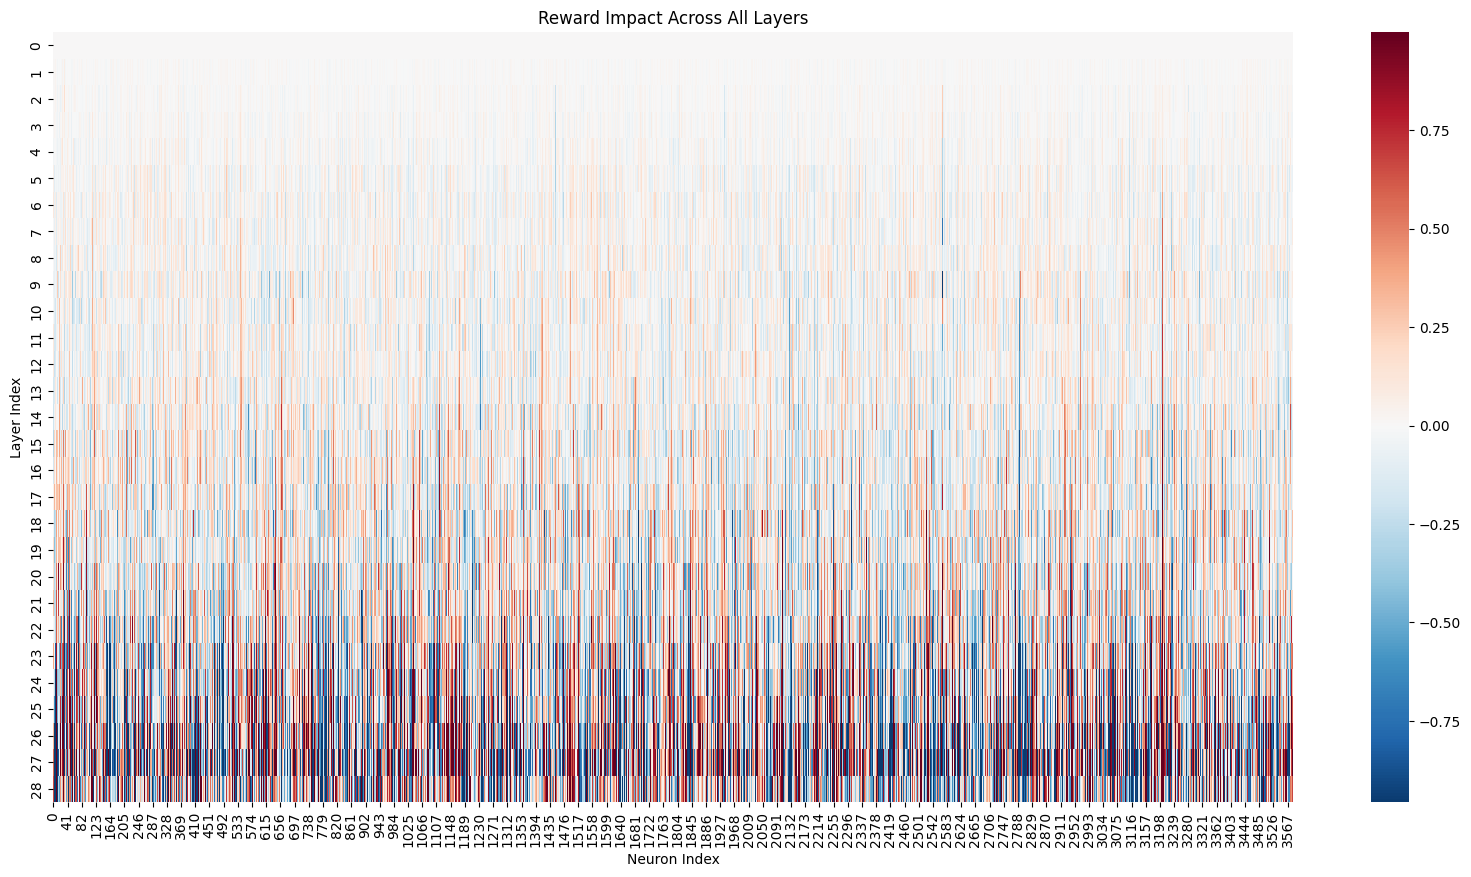

In [10]:
plt.figure(figsize=(20, 10))
sns.heatmap(delta_reward, cmap='RdBu_r', center=0, robust=True)
plt.title("Reward Impact Across All Layers")
plt.xlabel("Neuron Index")
plt.ylabel("Layer Index")
plt.show()

### Thresholding

In [11]:
threshold = 3 * np.std(delta_reward)
suspicious_indices = np.where(np.abs(delta_reward) > threshold)

# suspicious_indices[0] -> Layer indices
# suspicious_indices[1] -> Neuron indices
print(f"Found {len(suspicious_indices[0])} suspicious neurons.")

Found 2376 suspicious neurons.


### Top Sensitive Neurons

In [12]:
# Create a list of (Layer, Neuron, Change_Value)
important_neurons = []
for l, n in zip(suspicious_indices[0], suspicious_indices[1]):
    important_neurons.append({
        'Layer': l,
        'Neuron': n,
        'Change': delta_reward[l, n]
    })

# Sort by absolute change
important_neurons = sorted(important_neurons, key=lambda x: abs(x['Change']), reverse=True)

# Show Top 10
import pandas as pd
df_important = pd.DataFrame(important_neurons)
print(df_important)

      Layer  Neuron    Change
0        28    2127 -9.611252
1        28    2477 -9.333124
2        28    2529  7.837498
3        28    3577  7.057866
4        27    2570 -6.860001
...     ...     ...       ...
2371     26    1238 -1.213623
2372     26     944  1.213555
2373     28    2079  1.213516
2374     28    3182  1.213363
2375     26    2862 -1.213301

[2376 rows x 3 columns]


### Density Analysis

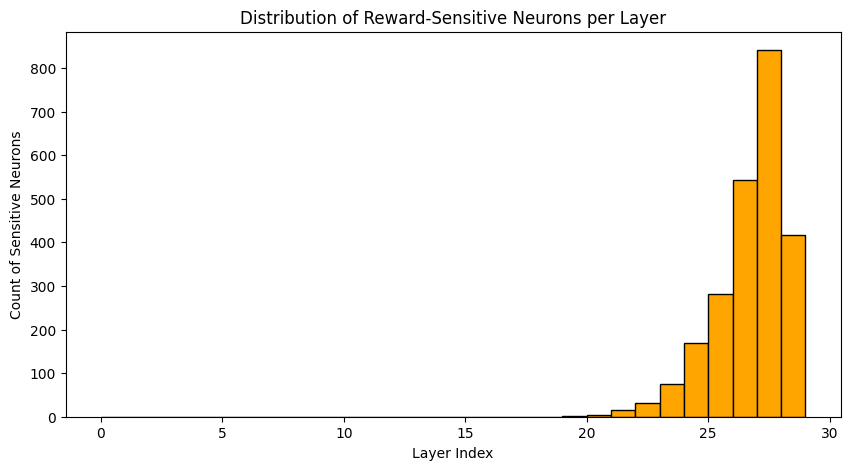

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(suspicious_indices[0], bins=range(30), color='orange', edgecolor='black')
plt.title("Distribution of Reward-Sensitive Neurons per Layer")
plt.xlabel("Layer Index")
plt.ylabel("Count of Sensitive Neurons")
plt.show()

In [14]:
# Create a set of unique (Layer, Neuron) tuples for Reward condition
reward_neuron_set = set(zip(suspicious_indices[0], suspicious_indices[1]))

# Store the top 100 most reactive neurons separately for high-precision comparison
top_reward_neurons = df_important[0:100]

print(f"Stored {len(reward_neuron_set)} unique neuron coordinates for Reward condition.")

Stored 2376 unique neuron coordinates for Reward condition.


## Money

In [15]:
# Load Money activations
data_money = torch.load("money_activations_v2.pt", map_location='cpu')

# Aggregate questions (q_1 to q_100)
raw_acts_money = np.stack([data_money[f"q_{i}"].float().numpy() for i in range(1, 101)])
mean_money = np.mean(raw_acts_money, axis=0)

# Calculate Delta for Money
delta_money = mean_money - mean_neutral

print(f"Money Delta calculated. Mean absolute change: {np.abs(delta_money).mean():.6f}")

Money Delta calculated. Mean absolute change: 0.297191


### The Overlap Test

In [16]:
# Find suspicious neurons for Money using the same threshold logic
threshold_m = 3 * np.std(delta_money)
suspicious_indices_m = np.where(np.abs(delta_money) > threshold_m)
money_neuron_set = set(zip(suspicious_indices_m[0], suspicious_indices_m[1]))

# Find the intersection (Common Neurons)
common_neurons = reward_neuron_set.intersection(money_neuron_set)

# Find unique neurons for each condition
only_reward = reward_neuron_set - money_neuron_set
only_money = money_neuron_set - reward_neuron_set

print(f"Money-sensitive neurons found: {len(money_neuron_set)}")
print(f"Common neurons between Reward and Money: {len(common_neurons)}")
print(f"Percentage of overlap: {(len(common_neurons) / len(reward_neuron_set)) * 100:.2f}%")

Money-sensitive neurons found: 2522
Common neurons between Reward and Money: 1002
Percentage of overlap: 42.17%


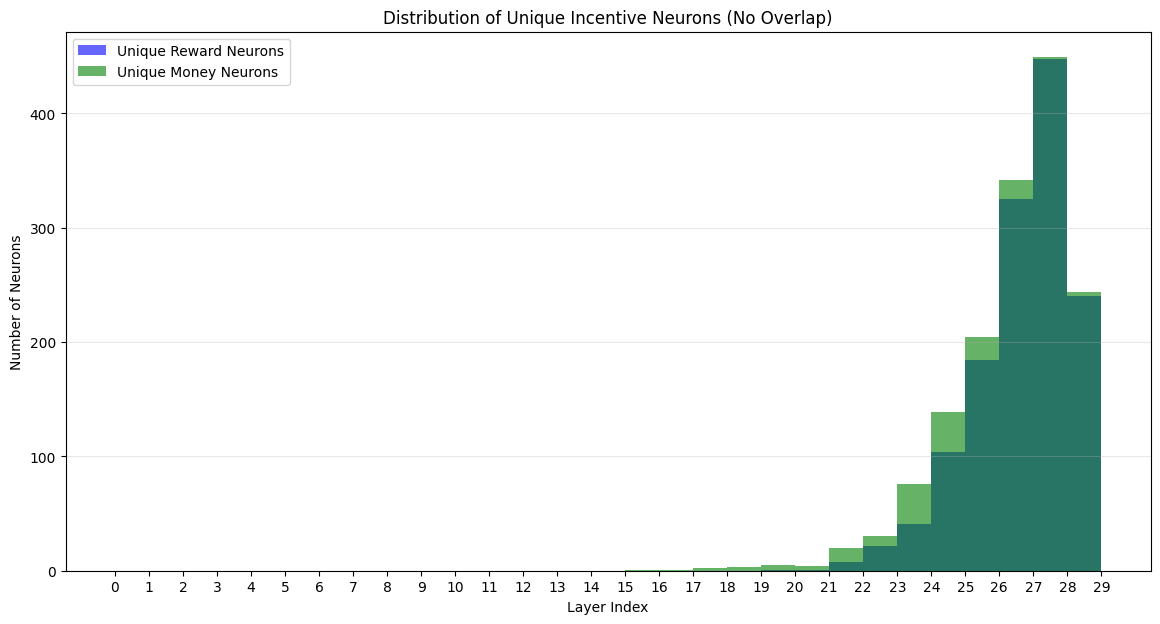

In [17]:
# Create lists for the unique neurons
only_reward_list = [n for n in reward_neuron_set if n not in money_neuron_set]
only_money_list = [n for n in money_neuron_set if n not in reward_neuron_set]

# Extract layers for visualization
reward_unique_layers = [n[0] for n in only_reward_list]
money_unique_layers = [n[0] for n in only_money_list]

plt.figure(figsize=(14, 7))

# Plotting the unique (non-overlapping) neurons
plt.hist(reward_unique_layers, bins=range(30), alpha=0.6, label='Unique Reward Neurons', color='blue')
plt.hist(money_unique_layers, bins=range(30), alpha=0.6, label='Unique Money Neurons', color='green')

plt.title("Distribution of Unique Incentive Neurons (No Overlap)")
plt.xlabel("Layer Index")
plt.ylabel("Number of Neurons")
plt.legend()
plt.xticks(range(30))
plt.grid(axis='y', alpha=0.3)
plt.show()

In [18]:
# Calculate Magnitude of change for different groups
common_list = list(common_neurons)
only_reward_list = list(reward_neuron_set - money_neuron_set)
only_money_list = list(money_neuron_set - reward_neuron_set)

def get_avg_magnitude(neuron_list, delta_matrix):
    values = [abs(delta_matrix[l, n]) for l, n in neuron_list]
    return np.mean(values)

print(f"--- Strength of Neural Signal ---")
print(f"Common Neurons Magnitude: {get_avg_magnitude(common_list, delta_reward):.4f}")
print(f"Unique Reward Neurons Magnitude: {get_avg_magnitude(only_reward_list, delta_reward):.4f}")
print(f"Unique Money Neurons Magnitude: {get_avg_magnitude(only_money_list, delta_money):.4f}")

--- Strength of Neural Signal ---
Common Neurons Magnitude: 1.8826
Unique Reward Neurons Magnitude: 1.5317
Unique Money Neurons Magnitude: 2.1024


In [19]:
# Function to calculate the weighted average layer (Center of Gravity)
def get_gravity_center(neuron_list, delta_matrix):
    if not neuron_list:
        return 0
    total_impact = sum(abs(delta_matrix[l, n]) for l, n in neuron_list)
    weighted_layer_sum = sum(l * abs(delta_matrix[l, n]) for l, n in neuron_list)
    return weighted_layer_sum / total_impact

# Calculate centers for the three groups
common_center = get_gravity_center(common_list, delta_reward)
reward_unique_center = get_gravity_center(only_reward_list, delta_reward)
money_unique_center = get_gravity_center(only_money_list, delta_money)

print(f"--- Spatial Center of Gravity (Layer Index) ---")
print(f"Common Reward-Money Nucleus: {common_center:.2f}")
print(f"Unique Verbal Reward Circuit: {reward_unique_center:.2f}")
print(f"Unique Monetary (Money) Circuit: {money_unique_center:.2f}")

# Detailed stats for Top 10 Money Neurons (to see where the 2.10 magnitude comes from)
top_money_units = sorted(only_money_list, key=lambda x: abs(delta_money[x[0], x[1]]), reverse=True)[:10]
print("\n--- Top 10 Most Powerful Money-Specific Neurons ---")
for l, n in top_money_units:
    print(f"Layer: {l} | Neuron: {n} | Magnitude: {abs(delta_money[l, n]):.4f}")

--- Spatial Center of Gravity (Layer Index) ---
Common Reward-Money Nucleus: 26.45
Unique Verbal Reward Circuit: 26.23
Unique Monetary (Money) Circuit: 25.97

--- Top 10 Most Powerful Money-Specific Neurons ---
Layer: 28 | Neuron: 162 | Magnitude: 6.8900
Layer: 28 | Neuron: 2303 | Magnitude: 5.9219
Layer: 28 | Neuron: 2334 | Magnitude: 5.1150
Layer: 28 | Neuron: 2948 | Magnitude: 4.6863
Layer: 27 | Neuron: 1786 | Magnitude: 4.4004
Layer: 21 | Neuron: 3110 | Magnitude: 4.3146
Layer: 22 | Neuron: 3110 | Magnitude: 4.1694
Layer: 28 | Neuron: 2072 | Magnitude: 4.0431
Layer: 26 | Neuron: 1786 | Magnitude: 3.8435
Layer: 20 | Neuron: 3110 | Magnitude: 3.7713


In [20]:
# Calculate Pearson Correlation between Reward Delta and Money Delta
from scipy.stats import pearsonr

# Flatten the matrices to compare all 118,784 units
correlation, _ = pearsonr(delta_reward.flatten(), delta_money.flatten())

print(f"Global Correlation between Reward and Money: {correlation:.4f}")

if correlation > 0.8:
    print("The model has a UNIFIED reward system (Low differentiation).")
elif correlation > 0.4:
    print("The model DIFFERENTIATES between material and verbal rewards.")
else:
    print("The model treats Money and Reward as COMPLETELY UNRELATED concepts.")

Global Correlation between Reward and Money: 0.6556
The model DIFFERENTIATES between material and verbal rewards.


In [21]:
# Finding neurons that have HIGH response to Money but LOW response to Reward
# We look for the maximum discrepancy
money_specific_signal = np.abs(delta_money) - np.abs(delta_reward)

# Get coordinates of neurons where Money impact is much stronger than Reward impact
m_specific_indices = np.where(money_specific_signal > (2 * np.std(money_specific_signal)))

print(f"Found {len(m_specific_indices[0])} Pure Monetary Neurons.")

# Let's see the top 5 'Pure Money' neurons in the decision layer
pure_money_layer28 = []
for l, n in zip(m_specific_indices[0], m_specific_indices[1]):
    if l == 28:
        pure_money_layer28.append((n, money_specific_signal[l, n]))

pure_money_layer28 = sorted(pure_money_layer28, key=lambda x: x[1], reverse=True)
print("\nTop 5 Pure Monetary Neurons in Layer 28 (The Target for Financial Anhedonia):")
for n, val in pure_money_layer28[:5]:
    print(f"Neuron ID: {n} | Money-specific Strength: {val:.4f}")

Found 5149 Pure Monetary Neurons.

Top 5 Pure Monetary Neurons in Layer 28 (The Target for Financial Anhedonia):
Neuron ID: 115 | Money-specific Strength: 15.7456
Neuron ID: 523 | Money-specific Strength: 6.2150
Neuron ID: 162 | Money-specific Strength: 6.0775
Neuron ID: 2303 | Money-specific Strength: 5.3794
Neuron ID: 2334 | Money-specific Strength: 4.9575


# Experiment II

Loading Math data...
Loading Geography data...

--- Cross-Task Stability Report ---
Money-Incentive Correlation (Math vs Geo): 0.3225
Number of Global Money Neurons: 197


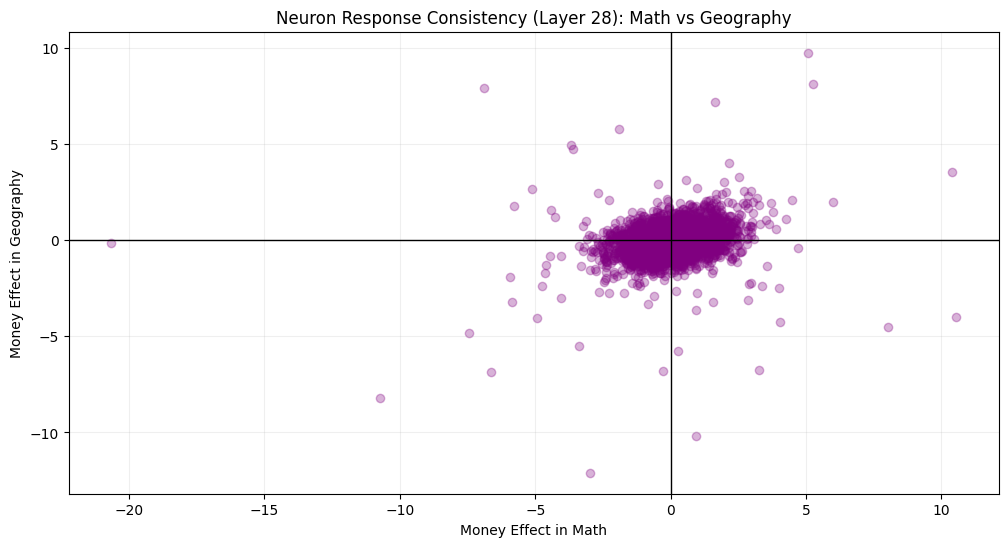

In [22]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_mean_act(file_path):
    data = torch.load(file_path, map_location='cpu')
    # Using the first 100 questions
    raw = np.stack([data[f"q_{i}"].float().numpy() for i in range(1, 101)])
    return np.mean(raw, axis=0)

# 1. Load Math Activations (from previous experiment)
print("Loading Math data...")
mean_neu_math = get_mean_act("neutral_activations_v2.pt")
mean_mon_math = get_mean_act("money_activations_v2.pt")
delta_mon_math = mean_mon_math - mean_neu_math

# 2. Load Geography Activations (new data)
print("Loading Geography data...")
# Assuming you named them with _geo suffix
mean_neu_geo = get_mean_act("neutral_activations_geo.pt")
mean_mon_geo = get_mean_act("money_activations_geo.pt")
delta_mon_geo = mean_mon_geo - mean_neu_geo

# 3. Calculate Cross-Task Correlation
from scipy.stats import pearsonr
# Correlation of Money-Effect between Math and Geography
corr_val, _ = pearsonr(delta_mon_math.flatten(), delta_mon_geo.flatten())

print(f"\n--- Cross-Task Stability Report ---")
print(f"Money-Incentive Correlation (Math vs Geo): {corr_val:.4f}")

# 4. Identify Global Money Neurons
# Neurons that are in Top 1% of both tasks
threshold_math = np.percentile(np.abs(delta_mon_math), 99)
threshold_geo = np.percentile(np.abs(delta_mon_geo), 99)

global_money_indices = np.where((np.abs(delta_mon_math) > threshold_math) & 
                                (np.abs(delta_mon_geo) > threshold_geo))

print(f"Number of Global Money Neurons: {len(global_money_indices[0])}")

# 5. Visualizing the Overlap
plt.figure(figsize=(12, 6))
plt.scatter(delta_mon_math[28], delta_mon_geo[28], alpha=0.3, color='purple')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.title("Neuron Response Consistency (Layer 28): Math vs Geography")
plt.xlabel("Money Effect in Math")
plt.ylabel("Money Effect in Geography")
plt.grid(True, alpha=0.2)
plt.show()

Loading Reward data for Math and Geo tasks...

--- Verbal Reward Stability Analysis ---
Global Correlation (Math vs Geo): 0.5254
Universal Verbal Neurons (UVNs) Found: 680


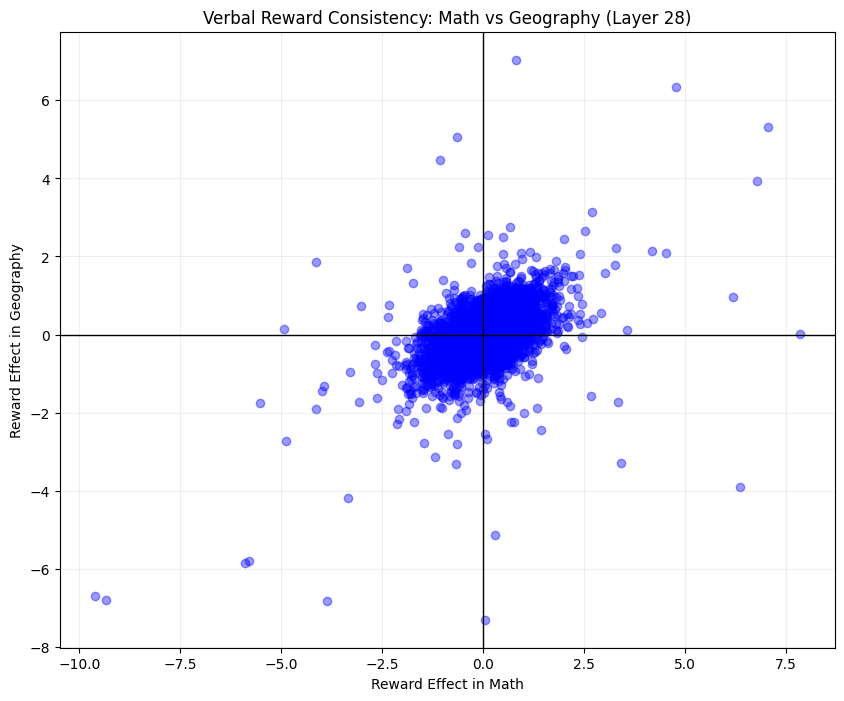

In [24]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def get_mean_act(file_path):
    # Load activation dictionary
    data = torch.load(file_path, map_location='cpu')
    # Stack first 100 questions into a numpy array
    raw = np.stack([data[f"q_{i}"].float().numpy() for i in range(1, 101)])
    # Return mean across questions (shape: layers, neurons)
    return np.mean(raw, axis=0)

# 1. Load Math and Geography Activations
print("Loading Reward data for Math and Geo tasks...")
delta_rew_math = get_mean_act("reward_activations_v2.pt") - get_mean_act("neutral_activations_v2.pt")
delta_rew_geo = get_mean_act("reward_activations_geo.pt") - get_mean_act("neutral_activations_geo.pt")

# 2. Global Correlation Test
global_corr, _ = pearsonr(delta_rew_math.flatten(), delta_rew_geo.flatten())

# 3. Identify Universal Verbal Neurons (UVNs)
# Criteria: Absolute change > 3 standard deviations in both tasks
threshold_math = 3 * np.std(delta_rew_math)
threshold_geo = 3 * np.std(delta_rew_geo)

uvn_idx = np.where((np.abs(delta_rew_math) > threshold_math) & 
                   (np.abs(delta_rew_geo) > threshold_geo))

print(f"\n--- Verbal Reward Stability Analysis ---")
print(f"Global Correlation (Math vs Geo): {global_corr:.4f}")
print(f"Universal Verbal Neurons (UVNs) Found: {len(uvn_idx[0])}")

# 4. Visualization of Consistency in Layer 28
plt.figure(figsize=(10, 8))
plt.scatter(delta_rew_math[28], delta_rew_geo[28], alpha=0.4, color='blue')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.title("Verbal Reward Consistency: Math vs Geography (Layer 28)")
plt.xlabel("Reward Effect in Math")
plt.ylabel("Reward Effect in Geography")
plt.grid(True, alpha=0.2)
plt.savefig("reward_consistency_plot.png")
plt.show()

# 5. Extract UVN coordinates for further lesioning
df_uvn = pd.DataFrame({'Layer': uvn_idx[0], 'Neuron': uvn_idx[1]})
df_uvn.to_csv("universal_verbal_neurons.csv", index=False)

In [25]:
import pandas as pd
import numpy as np

# 1. Defining thresholds for Reward (using same logic as Money)
threshold_rew_math = 3 * np.std(delta_rew_math)
threshold_rew_geo = 3 * np.std(delta_rew_geo)

# 2. Extracting sets of (Layer, Neuron) for both types of Universal Neurons
# Money Universal Neurons (from previous step)
money_universal_set = set(zip(urn_indices[0], urn_indices[1]))

# Verbal Reward Universal Neurons
reward_universal_set = set(zip(uvn_idx[0], uvn_idx[1]))

# 3. Finding the Intersection (The Master Core)
master_core_neurons = money_universal_set.intersection(reward_universal_set)

# 4. Finding Specific Neurons (Anhedonia Targets)
only_money_universal = money_universal_set - reward_universal_set
only_reward_universal = reward_universal_set - money_universal_set

print(f"--- Global Incentive Anatomy ---")
print(f"Universal Money Neurons: {len(money_universal_set)}")
print(f"Universal Verbal Neurons: {len(reward_universal_set)}")
print(f"Common Master Core Neurons: {len(master_core_neurons)}")
print(f"Percentage of Overlap: {(len(master_core_neurons)/len(money_universal_set))*100:.2f}%")

# 5. Saving the Master Core for Lesioning Phase
df_master = pd.DataFrame(list(master_core_neurons), columns=['Layer', 'Neuron'])
df_master.to_csv("master_incentive_core.csv", index=False)

--- Global Incentive Anatomy ---
Universal Money Neurons: 502
Universal Verbal Neurons: 680
Common Master Core Neurons: 234
Percentage of Overlap: 46.61%


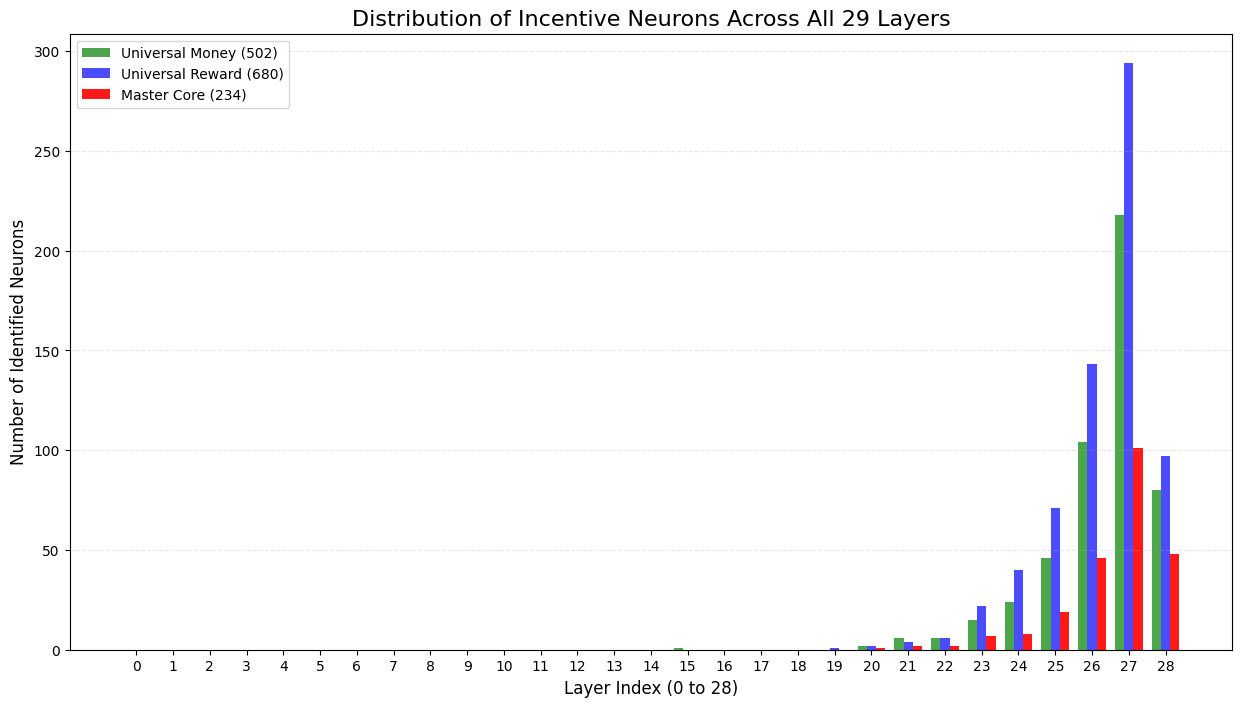

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract layer indices from our identified groups
money_universal_layers = urn_indices[0]
reward_universal_layers = uvn_idx[0]
master_core_layers = [n[0] for n in master_core_neurons]

# 2. Setup the plot
plt.figure(figsize=(15, 8))
layers = np.arange(29)

# 3. Calculate counts per layer for each group
money_counts = [np.sum(money_universal_layers == l) for l in layers]
reward_counts = [np.sum(reward_universal_layers == l) for l in layers]
master_counts = [np.sum(np.array(master_core_layers) == l) for l in layers]

# 4. Plotting
width = 0.25
plt.bar(layers - width, money_counts, width, label='Universal Money (502)', color='green', alpha=0.7)
plt.bar(layers, reward_counts, width, label='Universal Reward (680)', color='blue', alpha=0.7)
plt.bar(layers + width, master_counts, width, label='Master Core (234)', color='red', alpha=0.9)

# 5. Formatting
plt.title("Distribution of Incentive Neurons Across All 29 Layers", fontsize=16)
plt.xlabel("Layer Index (0 to 28)", fontsize=12)
plt.ylabel("Number of Identified Neurons", fontsize=12)
plt.xticks(layers)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

In [2]:
import os
import torch
import numpy as np
import pandas as pd

# --- Configuration ---
# Adjust these paths to where your .pt files are located
BASE_PATH = "../phase1"
ACTIVATIONS_DIR = os.path.join(BASE_PATH, "activations")

# File Names (Math)
MATH_NEUTRAL = "neutral_activations_v2.pt"
MATH_MONEY = "money_activations_v2.pt"
MATH_REWARD = "reward_activations_v2.pt"

# File Names (Geography - Logic from notebook)
# Assuming typical naming convention. Update if yours are different.
GEO_NEUTRAL = "neutral_activations_geo.pt"
GEO_MONEY = "money_activations_geo.pt"
GEO_REWARD = "reward_activations_geo.pt"

OUTPUT_MONEY = "universal_money_neurons.csv"
OUTPUT_REWARD = "universal_reward_neurons.csv"

TOP_K = 3000  # The pool size from which we find the intersection

def load_activation_mean(filename):
    # Try searching in base path and activations subfolder
    paths_to_check = [
        os.path.join(BASE_PATH, filename),
        os.path.join(ACTIVATIONS_DIR, filename),
        filename # Current directory check
    ]
    
    found_path = None
    for p in paths_to_check:
        if os.path.exists(p):
            found_path = p
            break
            
    if not found_path:
        raise FileNotFoundError(f"Could not find {filename} in search paths.")
        
    print(f"Loading {found_path}...")
    data = torch.load(found_path)
    
    # Calculate Mean
    tensors = []
    # Keys might be q_1..q_100 or similar
    for k, v in data.items():
        if isinstance(v, torch.Tensor):
            tensors.append(v)
            
    if not tensors:
        raise ValueError(f"No tensors found in {filename}")
        
    # Stack and Mean -> [Layers, Hidden]
    # Assuming shape [100, 29, 4096]
    return torch.stack(tensors).float().mean(dim=0)

def find_intersection(delta1, delta2, top_k):
    # Flatten or calculate magnitude per neuron across layers?
    # Usually we look at the whole network or specific layers.
    # Let's use the magnitude sum across all layers for robustness
    # or the max layer. The notebook likely used a specific strategy.
    # We'll use: Total Magnitude across all layers
    
    score1 = torch.sum(torch.abs(delta1), dim=0).numpy() # Shape [4096]
    score2 = torch.sum(torch.abs(delta2), dim=0).numpy()
    
    top1 = np.argsort(score1)[-top_k:]
    top2 = np.argsort(score2)[-top_k:]
    
    intersection = np.intersect1d(top1, top2)
    return intersection

def main():
    print("--- Extracting Universal Neurons ---")
    
    try:
        # 1. Load Math Data
        print("\nLoading Math Activations...")
        m_neu = load_activation_mean(MATH_NEUTRAL)
        m_mon = load_activation_mean(MATH_MONEY)
        m_rew = load_activation_mean(MATH_REWARD)
        
        # 2. Load Geo Data
        print("\nLoading Geography Activations...")
        try:
            g_neu = load_activation_mean(GEO_NEUTRAL)
            g_mon = load_activation_mean(GEO_MONEY)
            g_rew = load_activation_mean(GEO_REWARD)
        except FileNotFoundError:
            print("WARNING: Geography files not found. Cannot calculate intersection.")
            print("Please ensure geo_*.pt files are in phase1/ or phase1/activations/")
            return

        # 3. Calculate Deltas
        print("\nCalculating Deltas...")
        # Math Deltas
        d_math_money = m_mon - m_neu
        d_math_reward = m_rew - m_neu
        
        # Geo Deltas
        d_geo_money = g_mon - g_neu
        d_geo_reward = g_rew - g_neu
        
        # 4. Find Universal Money Neurons (The 502)
        print(f"\nFinding Intersection for MONEY (Target: ~502)...")
        univ_money = find_intersection(d_math_money, d_geo_money, TOP_K)
        print(f"-> Found {len(univ_money)} Universal Money Neurons.")
        
        # 5. Find Universal Reward Neurons (The 680)
        print(f"\nFinding Intersection for REWARD (Target: ~680)...")
        univ_reward = find_intersection(d_math_reward, d_geo_reward, TOP_K)
        print(f"-> Found {len(univ_reward)} Universal Reward Neurons.")
        
        # 6. Save to CSV
        pd.DataFrame({'neuron_index': univ_money}).to_csv(OUTPUT_MONEY, index=False)
        pd.DataFrame({'neuron_index': univ_reward}).to_csv(OUTPUT_REWARD, index=False)
        
        print(f"\nSUCCESS! Saved to:")
        print(f" - {OUTPUT_MONEY}")
        print(f" - {OUTPUT_REWARD}")
        
    except Exception as e:
        print(f"\nERROR: {e}")

if __name__ == "__main__":
    main()

--- Extracting Universal Neurons ---

Loading Math Activations...
Loading ../phase1/activations/neutral_activations_v2.pt...
Loading ../phase1/activations/money_activations_v2.pt...
Loading ../phase1/activations/reward_activations_v2.pt...

Loading Geography Activations...
Loading ../phase1/activations/neutral_activations_geo.pt...
Loading ../phase1/activations/money_activations_geo.pt...
Loading ../phase1/activations/reward_activations_geo.pt...

Calculating Deltas...

Finding Intersection for MONEY (Target: ~502)...
-> Found 2543 Universal Money Neurons.

Finding Intersection for REWARD (Target: ~680)...
-> Found 2577 Universal Reward Neurons.

SUCCESS! Saved to:
 - universal_money_neurons.csv
 - universal_reward_neurons.csv
